In [3]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_json('tops_fashion.json')

print("No. of data points :", data.shape[0], "No. of features/variables :", data.shape[1])

No. of data points : 183138 No. of features/variables : 19


In [3]:
data.columns

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')

In [4]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

print("No. of data points :", data.shape[0], "No. of features/variables :", data.shape[1])

No. of data points : 183138 No. of features/variables : 7


In [5]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


In [6]:
print(data.describe())

              asin   brand  color  \
count       183138  182987  64956   
unique      183138   10577   7380   
top     B01N9MM0J8    Zago  Black   
freq             1     223  13207   

                                         medium_image_url product_type_name  \
count                                              183138            183138   
unique                                             170782                72   
top     https://images-na.ssl-images-amazon.com/images...             SHIRT   
freq                                                   23            167794   

                                                    title formatted_price  
count                                              183138           28395  
unique                                             175985            3135  
top     Nakoda Cotton Self Print Straight Kurti For Women          $19.99  
freq                                                   77             945  


In [7]:
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395
Number of data points After eliminating color=NULL : 28385


In [9]:
print(sum(data.duplicated('title')))

2325


In [10]:
data_sorted = data[data['title'].apply(lambda x: len(x.split()) > 4)]
print("After removal of short titles: ", data_sorted.shape[0])

After removal of short titles:  27949


In [11]:
data_sorted.  sort_values('title', inplace = True)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
118987,B008D30AGK,Out+of+Print+Clothing,Multicolored,https://images-na.ssl-images-amazon.com/images...,SHIRT,"""1984"" Retro Book Cover Women's SLim Fit T-Shi...",$7.51
78827,B003IDE8XQ,Maggie's Organics,Grey,https://images-na.ssl-images-amazon.com/images...,HOME,"""Camisoles Grey - Medium Fair Labor, 1 pc""",$18.99
109599,B00KI3VDXM,Crazy4Bling,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,"""I Wanna Be Adored"" Long Sleeve Top with Shred...",$39.99
40451,B073SKNQHD,The Workout Princess,Premium Heather Gray,https://images-na.ssl-images-amazon.com/images...,SHIRT,"""I Workout To Burn off The Crazy"", Tri Blend T...",$24.99
12050,B06WRW8RQ1,AJ,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,"""Life is a Journey"" Self-Help DIY T-Shirt (Wom...",$9.38


In [12]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [14]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    previous_i = i
    a = data['title'].loc[indices[i]].split()
    j = i+1
    while j < num_data_points:
        b = data['title'].loc[indices[j]].split()
        max_length = max(len(a), len(b))
        count = 0
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1
        if (max_length - count) > 2:
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])
            if j == num_data_points-1:
                stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break
                    

In [15]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]
print('Number of data points : ', data.shape[0])

Number of data points :  17587


In [16]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    a = data['title'].loc[i].split()
    for j in indices:
        
        b = data['title'].loc[j].split()
        
        length = max(len(a),len(b))
        
        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        if (length - count) < 3:
            indices.remove(j)

In [17]:
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]
print('Number of data points after stage two of dedupe: ',data.shape[0])

Number of data points after stage two of dedupe:  16437


In [18]:
data.to_pickle('clean_data')
print("Pickle complete... You may stop the job")

Pickle complete... You may stop the job


In [4]:
data = pd.read_pickle("clean_data")

In [5]:
stop_words = set(stopwords.words("english"))
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            #This removes any special characters, if any...
            word = ("".join(x for x in words if x.isalnum()))
            #This converts all words to lowercase...
            word = word.lower()
            if not word in stop_words:
                string += word + " "
        data[column][index] = string
            

In [6]:
for index, row in data.iterrows():
    nlp_preprocessing(row["title"], index, "title")

In [7]:
def display_img(url,ax,fig):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
  
def plot_heatmap(keys, values, labels, url, text):
       gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        ax = plt.subplot(gs[0])
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        ax = plt.subplot(gs[1])
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        display_img(url, ax, fig)
        
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):
  for i in vec2:
        if i not in intersection:
            vec2[i]=0

    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]
   
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    vector1 = text_to_vector(text1)

    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16437, 12683)

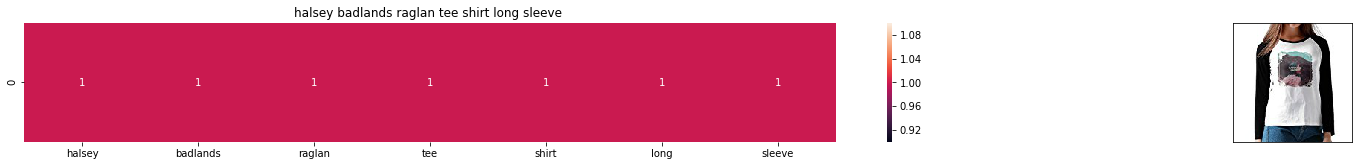

ASIN : B01MG000KS
Brand: PERI
Title: halsey badlands raglan tee shirt long sleeve 
Euclidean similarity with the query image : 0.0


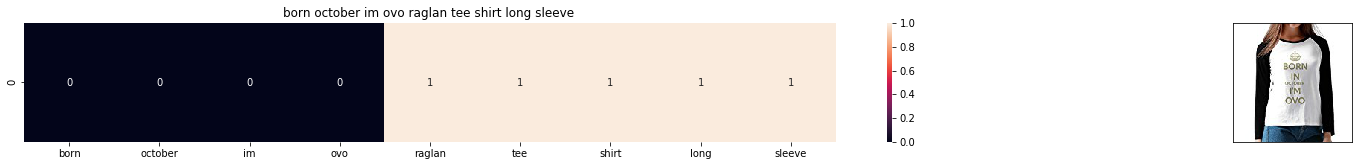

ASIN : B01MG29HY8
Brand: PERI
Title: born october im ovo raglan tee shirt long sleeve 
Euclidean similarity with the query image : 2.44948974278


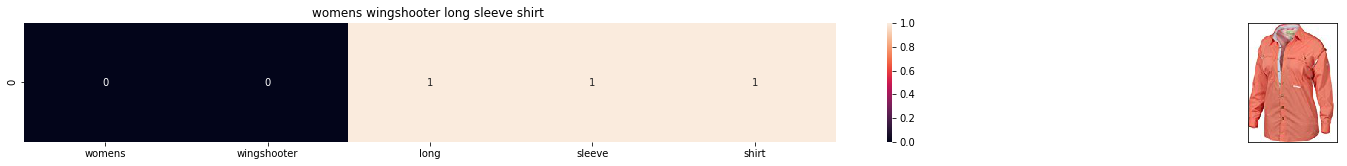

ASIN : B01BNWY6CQ
Brand: Drake
Title: womens wingshooter long sleeve shirt 
Euclidean similarity with the query image : 2.44948974278


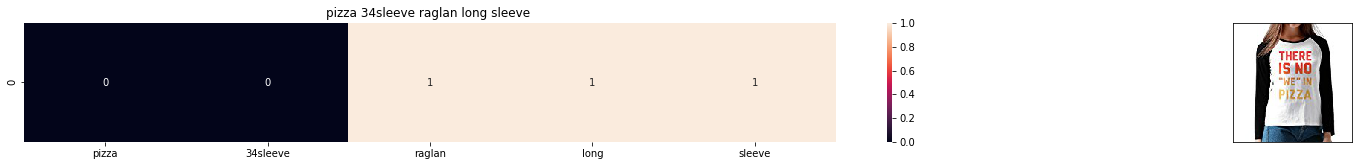

ASIN : B01MPZYO3E
Brand: PERI
Title: pizza 34sleeve raglan long sleeve 
Euclidean similarity with the query image : 2.44948974278


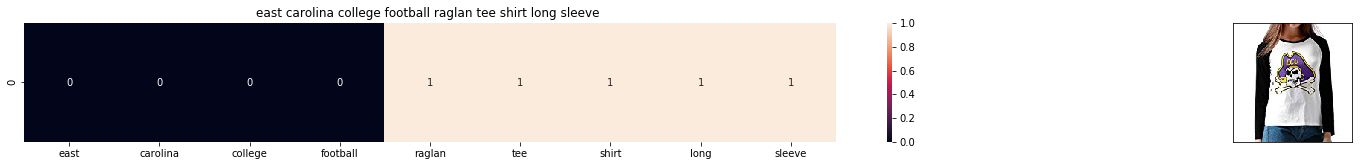

ASIN : B01MFAZASB
Brand: PERI
Title: east carolina college football raglan tee shirt long sleeve 
Euclidean similarity with the query image : 2.44948974278


In [52]:
def bag_of_words_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(title_features, title_features[doc_id])
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
bag_of_words_model(12921, 5)